[View in Colaboratory](https://colab.research.google.com/github/vincent-pli/machine-learning/blob/master/lris_prediction.ipynb)

In [0]:
!pip install -q --upgrade tensorflow

In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe


tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.8.0
Eager execution: True


In [2]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname = os.path.basename(train_dataset_url), origin=train_dataset_url)

print("Local cop of the dataset file: {}".format(train_dataset_fp))

16384/2194 [================================================================================================================================================================================================================================] - 0s 0us/step
Local cop of the dataset file: /content/.keras/datasets/iris_training.csv


In [4]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


example features: tf.Tensor([5.7 4.4 1.5 0.4], shape=(4,), dtype=float32)
example label: tf.Tensor(0, shape=(), dtype=int32)
Epoch 000: Loss: 1.760, AccuractL  30.000%
Epoch 050: Loss: 0.970, AccuractL  35.000%
Epoch 100: Loss: 0.670, AccuractL  72.500%
Epoch 150: Loss: 0.425, AccuractL  87.500%
Epoch 200: Loss: 0.297, AccuractL  95.833%


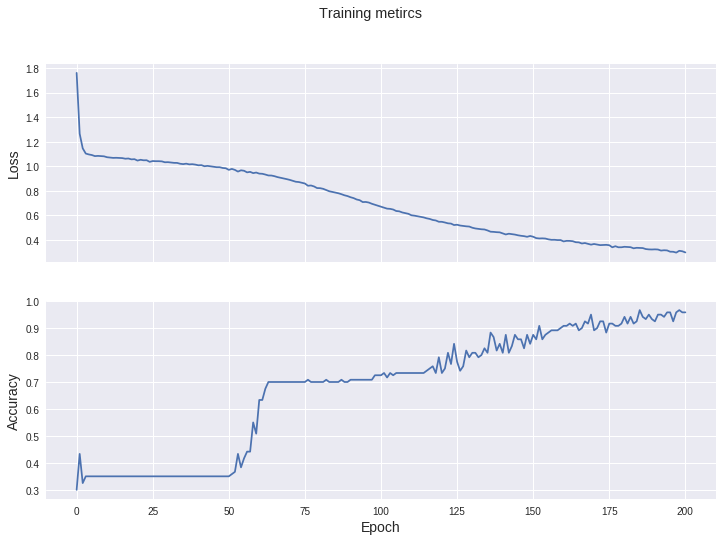

In [24]:
def parse_csv(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0]]
  parsed_line = tf.decode_csv(line, example_defaults)
  
  features = tf.reshape(parsed_line[:-1], shape=(4,))
  label = tf.reshape(parsed_line[-1], shape=())
  return features, label

train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)

train_dataset = train_dataset.map(parse_csv)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(32)

features, label = iter(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])


model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(3)
])

def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()
  
  for x, y in train_dataset:
    grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                             global_step=tf.train.get_or_create_global_step())
    
    epoch_loss_avg(loss(model, x, y))
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
  
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, AccuractL {: .3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

   
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle("Training metircs")

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

    
    

In [28]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"
test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                 origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)
test_dataset = test_dataset.map(parse_csv)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(32)

test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)
  
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))


Test set accuracy: 93.333%


In [29]:
class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]
predict_dataset = tf.convert_to_tensor([[5.1, 3.3, 1.7, 0.5,],[5.9, 3.0, 4.2, 1.5,],[6.9, 3.1, 5.4, 2.1]])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  name = class_ids[class_idx]
  print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris setosa
Example 1 prediction: Iris versicolor
Example 2 prediction: Iris virginica
